## Abstract

Lo scopo di questo progetto è quello di realizzare una base di conoscenza per dei corpi celesti, in particolare comete, asteroidi e meteoriti, in modo da fornire per i primi due, ovvero i NearEarthObjects, dati per la ricostruzione delle loro orbite, mentre per i meteoriti una classificazione in base ai tipi degli stessi ed degli impatti, avvenuti o meno nonchè osservati o meno, con la superficie terrestre. Per fare ciò verrà adoperato un bot telegram che rielaborando i dati ottenuti da alcune query eseguite sulla nostra base di conoscenza, che una volta eseguiti i passaggi di pulizia dei dati, creazione dell'ontologia e delle triple RDF, ed interlinking, saranno LOD (Linked Open Data), saremo in grado di fare esplorazione e ricerca su tali dati e, in base al tipo di corpo celeste, la ricostruzione dell'orbita, accompagnata da uno studio sulla posizione del corpo ad un determinato istante di tempo sull'orbita stessa, oppure la visualizzazione dei siti di impatto nel caso di meteoriti.

## Datasets

I dataset utilizzati riguardano ovviamente Comete, Asteroidi e Meteoriti, tutti presi dal portale Open Data della NASA. Per quanto riguarda i dataset delle Comete e degli Asteroidi viene specificato nei metadati che il produttore dei dati è il __Jet Propulsion Laboratory__, possiamo quindi prendere i dati direttamente dal database __Small-Body Database__.
- __Meteoriti__ : https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh/about_data
- __Comete/Asteroidi__ : https://ssd.jpl.nasa.gov/tools/sbdb_query.html

Per quanto riguarda la licenza dei dati, per tutti e 3 i dataset questa non viene specificata, pertanto, come viene riportato in https://science.data.nasa.gov/license/, hanno licenza  __CC0__.

# Meteoriti

In [1]:
import pandas as pd
import requests
from ast import literal_eval
df = pd.read_csv("Meteorites/Meteorite_Landings_20240306.csv")
df_c = df.copy() 

### Analisi colonna Name

In [2]:
name = df['name']
name_count = name.apply(lambda x: isinstance(x, str)).sum()
name_empty = name.apply(lambda x : x == '').sum()
name_na = name.isnull().sum()

print(f'Entries:{name.count()}, string:{name_count}, empty:{name_empty}, NA:{name_na}')

# Serie booleana dei nomi che contengono uno spazio alla fine o all'inizio della stringa
white_space = name.apply(lambda x : x[0] == ' ' or x[-1] == ' ')
# White contiene le entries del dataframe corrispondenti al valore True nella serire precedente
white = df[white_space]
white_id = white['id']
print(white['name'])

df_c['name'] = df_c['name'].apply(lambda x : x.strip())
df_c['name'] = df_c['name'].astype(str)

Entries:45716, string:45716, empty:0, NA:0
195                    Chergach 
5866           Dar al Gani 1049 
5868           Dar al Gani 1050 
16942    Jiddat al Harasis 479  
36753              San Juan 008 
Name: name, dtype: object


### Analisi colonna ID

In [4]:
id = df['id']
id_count = id.count()
id_integers = id.apply(lambda x : isinstance(x, int)).sum()
id_na = id.isnull().sum()
id_unique = id.nunique()
print(f'Entries:{id_count}, interi:{id_integers}, NA:{id_na}, Unici:{id_unique}')
df_c['id'] = df_c['id'].astype(int)

Entries:45716, interi:45716, NA:0, Unici:45716


### Analisi colonna Nametype

In questa colonna viene fatta una classificazione in base alla degradazione del meteorite, Valid significa che si tratta di un classico meteorite, mentre Relict indica un meteorite fortemente degradato dagli eventi meteorologici terrestri

In [5]:
nametype = df['nametype']
nametype_count = nametype.count()
nametype_valid = nametype[nametype == 'Valid'].count()
nametype_relict = nametype[nametype == 'Relict'].count()
nametype_null = nametype.isnull().sum()
print(f'Entries:{nametype_count}, Valid:{nametype_valid}, Relict:{nametype_relict}, NA:{nametype_null}')
if (nametype_relict + nametype_valid == name_count): print("Numero di entries coerente")

df_c['nametype'] = df_c['nametype'].astype(str)

Entries:45716, Valid:45641, Relict:75, NA:0
Numero di entries coerente


### Analisi colonna Recclass

In [6]:
recclass = df['recclass']
recclass_count = recclass.count()
recclass_string = recclass.apply(lambda x : isinstance(x, str)).sum()
recclass_empty = recclass.apply(lambda x : x == ' ').sum()
recclass_na = recclass.isnull().sum()

print(f'Entries:{recclass_count}, string:{recclass_string}, empty:{recclass_empty}, NA:{recclass_na}')

recclass_white_space = recclass.apply(lambda x : x[0] == ' ' or x[-1] == ' ')
recclass_white = df[recclass_white_space]
n_white = recclass_white['name'].count()
print(f'Numero di stringhe nella colonna recclass che iniziano o finiscono con uno spazio vuoto: {n_white}')

valori_unici_recclass = df['recclass'].value_counts().reset_index()
valori_unici_recclass.columns = ['recclass', 'conteggio']
n_dataframe = pd.DataFrame({'recclass': valori_unici_recclass['recclass'], 'conteggio': valori_unici_recclass['conteggio']})
#print(n_dataframe)

sp_count = 0
for va in recclass.unique():
    if va[0] == ' ' or va[-1] == ' ': sp_count +=1
print(f'{sp_count} classi vengono utilizzate con uno spazio all\'inizio o alla fine, pertanto vengono considerati anche questi nei 466 valori unici')

sp_val = [va for va in recclass.unique() if va[0] == ' ' or va[-1] == ' ']
print(f'Le classi in questione sono le seguenti: {sp_val}')

df_c['recclass'] = df_c['recclass'].apply(lambda x : x.strip())
df_c['recclass'] = df_c['recclass'].apply(lambda x : 'Acapulcoite/Lodranite' if x == 'Acapulcoite/lodranite' else x)
df_c['recclass'] = df_c['recclass'].astype(str)

Entries:45716, string:45716, empty:0, NA:0
Numero di stringhe nella colonna recclass che iniziano o finiscono con uno spazio vuoto: 118
11 classi vengono utilizzate con uno spazio all'inizio o alla fine, pertanto vengono considerati anche questi nei 466 valori unici
Le classi in questione sono le seguenti: ['H5 ', 'L5 ', 'H4 ', 'L4 ', 'L6 ', 'H3 ', 'LL6 ', 'H6 ', 'CO3 ', 'CH3 ', 'EL6 ']


### Analisi colonna Mass

In [7]:
mass = df['mass (g)']

# I valori nan vengono considerati float quidni dobbiamo considerare anche questo caso
mass_count = mass.apply(lambda x: isinstance(x, float) and not pd.isnull(x)).sum()
mass_null = mass.isnull().sum()
print(f'Entries: {mass_count}, Nan: {mass_null}, expected total: {len(mass)}, actual total: {mass_null + mass_count}')

pos = mass.gt(0).sum()
neg = mass.lt(0).sum()
zero = mass.eq(0).sum()
print(f'positive: {pos}, negative: {neg}, zero: {zero}, null: {mass_null}')

# Come possiamo vedere abbiamo una serie di meteoriti Österplana, un meteorite Gove ed infine Miller Range 090478
print(df[df['name'].str.contains('Österplana')].count())
#df_c.rename(columns={'mass (g)': 'mass'}, inplace=True)
# Fare lo studio sui Miller Range
print(df[(df['mass (g)'].isnull())])

df_c.fillna({'mass (g)': -1.0}, inplace=True)
df_c['mass (g)'] = df_c['mass (g)'].astype(float)

Entries: 45585, Nan: 131, expected total: 45716, actual total: 45716
positive: 45566, negative: 0, zero: 19, null: 131
name           63
id             63
nametype       63
recclass       63
mass (g)       17
fall           63
year           62
reclat         63
reclong        63
GeoLocation    63
dtype: int64
                    name     id nametype      recclass  mass (g)   fall  \
12       Aire-sur-la-Lys    425    Valid       Unknown       NaN   Fell   
38                Angers   2301    Valid            L6       NaN   Fell   
76     Barcelona (stone)   4944    Valid            OC       NaN   Fell   
93              Belville   5009    Valid            OC       NaN   Fell   
172    Castel Berardenga   5292    Valid    Stone-uncl       NaN   Fell   
...                  ...    ...      ...           ...       ...    ...   
38282     Wei-hui-fu (a)  24231    Valid          Iron       NaN  Found   
38283     Wei-hui-fu (b)  24232    Valid          Iron       NaN  Found   
38285        

Abbiamo 63 meteoriti appartenenti alla serie Österplana 17 dei quali hanno massa pari a 0 mentre i restanti 46 hanno massa nulla. La massa pari a 0 sembra essere dovuta al fatto tali meteoriti sono fossili trovati in delle cave in Svezia, essendo ormai logori sono essenzialmente delle rocce dalle quali però non c'è più modo di carpire la massa originale del meteorite.

Stesso ragionamento viene applicato al meteorite Gove

### Analisi colonna fall

In questa colonna viene indicato se la caduta del meteorite è stata osservata, Fell, o meno, Found. 

In [8]:
fall = df['fall']
fell_count = fall[fall == 'Fell'].count()
found_count = fall[fall == 'Found'].count()
found_null = fall.isnull().sum()

print(f'Entries: {fall.count()}, Fell: {fell_count}, Found:{found_count}, Null: {found_null}')

df_c.fillna({'fall': ""}, inplace=True)
df_c['fall'] = df_c['fall'].astype(str)

Entries: 45716, Fell: 1107, Found:44609, Null: 0


### Analisi colonna year

Qui viene riportato l'anno in cui è stata osservata la caduta del meteorite o la sua scoperta, ciò dipende dal valore riportato nella colonna Fall. Per questo progetto siamo interessati solamente ai meteoriti osservati o scoperti tra il 2000 e il 2024.

In [9]:
year = df['year']
year_count = year.apply(lambda x: isinstance(x, float) and not pd.isnull(x)).sum() 
year_null = year.isnull().sum()

print(f'Entries: {year_count}, Null: {year_null}, Expected total: {len(year)}, Real total: {year_null + year_count}')

# Controlliamo se le date non presentano mai una cifra dopo il . se così fosse allora possiamo convertire la colonna da float32 a int
dec = 0
for i in year:
    if pd.isnull(i): continue
    integer, decimal = str(i).split('.')
    if int(decimal) != 0 : dec+=1
print(dec)

year_pos = year.gt(0).sum()
year_neg = year.lt(0).sum()
year_zero = year.eq(0).sum()
print(f'Positive: {year_pos}, Negative: {year_neg}, Zeros: {year_zero}')

df_c.fillna({'year': 0}, inplace=True)
df_c['year'] = df_c['year'].astype(int)
df_c = df_c[(df_c['year'] >= 2000) & (df_c['year'] <= 2024)]

Entries: 45425, Null: 291, Expected total: 45716, Real total: 45716
0
Positive: 45425, Negative: 0, Zeros: 0


### Analisi colonna reclat

In [10]:
rec = df['reclat']
rec_count = rec.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
rec_null = rec.isnull().sum()
rec_illegal = rec[(rec < -90) | (rec > 90)].count()

print(f'Entries: {rec_count}, real_total: {len(rec)}, expected_total: {rec_count + rec_null}, Null: {rec_null}, Ilegal_lat: {rec_illegal}')
df_c.fillna({'reclat': 0.0}, inplace=True)
df_c['reclat'] = df_c['reclat'].astype(float)

Entries: 38401, real_total: 45716, expected_total: 45716, Null: 7315, Ilegal_lat: 0


### Analisi colonna reclong

In [11]:
long = df['reclong']
long_count = long.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
long_null = long.isnull().sum()
long_illegal = long[(long < -180) | (long > 180)].count()

print(f'Entries: {long_count}, real_total: {len(long)}, expected_total: {long_null + long_count}, Null: {long_null}, Illegal_long: {long_illegal}')

ill_long = df[(df['reclong'] < -180) | (df['reclong'] > 180)] 
#print(ill_long)

# come possiamo vedere il problema sta nel fatto che in questo caso la longitudine sembra trovarsi nel formato da 0 a 360 anzichè nel classico -180 e 180
# per risolvere il problema ci basta sottrarre 360 da questo valore

# Assicuriamoci addesso che i valori nulli della latitudine si trovino nelle stesse righe della longitudine (ovvero che non si sia uno dei due nullo quando l'altro non lo è)
if(len(df[(df['reclat'].isnull()) & (df['reclong'].isnull())]) == long_null) : print('I valori nulli si trovano nella stessa riga')
df_c['reclong'] = df_c['reclong'].apply(lambda x : round(x-360, 5) if x > 180 else x)
id_tochange = df_c.loc[df['reclong'] > 180, 'id'].iloc[0]
c_lat = df_c.loc[df['reclong'] > 180, 'reclat'].iloc[0]
c_long = df_c.loc[df['id'] == 32789, 'reclong'].iloc[0]
c_geo = f'({c_lat}, {c_long})'
df_c.loc[df['id'] == id_tochange, 'GeoLocation'] = c_geo

print(df_c.loc[df_c['id'] == 32789, 'GeoLocation'].iloc[0])

righe_con_zero = (df_c['reclong'] == 0) & (df_c['reclat'] == 0)
print(righe_con_zero.sum())
#df_c['GeoLocation'] = df_c[df_c['id'].eq('32789')].apply(convert, axis = 1)

print(len(df_c))
df_c = df_c.dropna(subset=['reclong'])
df_c['reclong'] = df_c['reclong'].astype(float)

Entries: 38401, real_total: 45716, expected_total: 45716, Null: 7315, Illegal_long: 1
I valori nulli si trovano nella stessa riga
(-1.94617, -5.52667)
4504
19720


### Analisi colonna geolocation

In [12]:
geo = df['GeoLocation']
geo_string = geo.apply(lambda x : isinstance(x, str)).sum()
geo_null = geo.isnull().sum()

print(f'Entries: {len(geo)}, String: {geo_string}, Null: {geo_null}, real_tot: {geo_string + geo_null}')

# Adesso contrilliamo che i valori contenuti in questa colonna siano gli stessi di quelli contenuti nelle colonne reclong e reclat
wrong_counter = 0
for i, row in df.iterrows():
    if pd.isnull(row['GeoLocation']) and pd.isnull(row['reclat']) and pd.isnull(row['reclong']): continue
    lat, long = row['GeoLocation'].strip('()').split(', ')
    if row['reclat'] != float(lat) or row['reclong'] != float(long): wrong_counter+=1
print(wrong_counter)
df_c.fillna({'GeoLocation': '()'}, inplace=True)

df_c['GeoLocation'] = df_c['GeoLocation'].astype(str)

Entries: 45716, String: 38401, Null: 7315, real_tot: 45716
0


In [13]:
df_c.to_csv("Meteorites/ml_cleaned.csv", index=False)

# Comete

In [ ]:
import pandas as pd
import requests
df = pd.read_csv('Comets/comets.csv')
df_c = df.copy()

### Analisi colonna full_name

In [ ]:
full_name = df['full_name']
fn_count = full_name.apply(lambda x : isinstance(x, str)).sum()
fn_empty = full_name.apply(lambda x : x == '').sum()
fn_na = full_name.isnull().sum()

print(f'Entries:{full_name.count()}, string:{fn_count}, empty:{fn_empty}, NA:{fn_na}, total:{len(full_name)}')

df_c['full_name'] = df_c['full_name'].apply(lambda x : x.strip())
df_c['full_name'] = df_c['full_name'].astype(str)

Entries:3928, string:3928, empty:0, NA:0, total:3928


### Eliminazione delle colonne contenenti solo valori null

In [ ]:
null_columns = df.columns[df.isnull().all()]
print(null_columns)
df_c.drop(null_columns, axis=1, inplace=True)

Index(['pha', 'G', 'BV', 'UB', 'IR', 'spec_B', 'spec_T'], dtype='object')


### Analisi colonna name

In [ ]:
names = df_c['name']
n_count = names.apply(lambda x : isinstance(x, str)).sum()
n_empty = names.apply(lambda x : x == '').sum()
n_na = names.isnull().sum()
print(n_na, n_empty) 

null_rows = df[df['name'].isnull() | (df['name'] == "")]
complete_name_values = null_rows['full_name']
df_c.dropna(subset=['name'])

df_c.fillna({'name': ""}, inplace=True)
df_c['name'] = df_c['name'].astype(str)

print(f'Entries:{names.count()}, string:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(names)}, actual_total:{n_empty+n_na+n_count}')

114 0
Entries:3928, string:3814, empty:0, NA:114, total:3928, actual_total:3928


### Colonna n_obs_used

Qui viene riportato il numero di osservazione fatte per il calcolo e quindi la ricostruzione dell'orbita

In [ ]:
nou = df_c['n_obs_used']
dec = 0
nu = 0
for i in nou:
    if pd.isnull(i): 
        nu+=1
        continue
    if int(str(i).split('.')[1]) == 0 : dec+=1
print(f"Total: {len(nou)}, da convertire: {dec}, nulli: {nu}, uknown: {len(nou)-(dec+nu)}")

n_count = nou.apply(lambda x : isinstance(x, int) and not x == 0).sum()
n_empty = nou.apply(lambda x : x == 0).sum()
n_na = nou.isnull().sum()

df_c.fillna({'n_obs_used': 0}, inplace=True)
df_c['n_obs_used'] = df_c['n_obs_used'].astype(int)

print(f'Entries:{nou.count()}, int:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(nou)}, actual_total:{n_empty+n_na+n_count}')

Total: 3928, da convertire: 3857, nulli: 71, uknown: 0
Entries:3928, int:0, empty:0, NA:71, total:3928, actual_total:71


### Analisi colonna e

Qui viene indicata l'eccentricità dell'orbita

In [ ]:
e = df_c['e']
n_count = e.apply(lambda x : isinstance(x, float)).sum()
n_empty = e.apply(lambda x : x == '').sum()
n_na = e.isnull().sum()
df_c['e'] = df_c['e'].astype(float)

print(f'Entries:{e.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(e)}, actual_total:{n_empty+n_na+e.count()}')

Entries:3928, float:3928, empty:0, NA:0, total:3928, actual_total:3928


### Analisi colonna a

In questa colonna troviamo i valori riguardanti il semiasse maggiore dell'orbita

In [ ]:
df_c = df_c.dropna(subset=['a'])
a = df_c['a']
n_count = a.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = a.apply(lambda x : x == '').sum()
n_na = a.isnull().sum()
df_c['a'] = df_c['a'].astype(float)

print(f'Entries:{a.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(a)}, actual_total:{n_empty+n_count + n_na}')

Entries:2165, float:2165, empty:0, NA:0, total:2165, actual_total:2165


### Analisi colonna i

Questa colonna contiene il valore dell'inclinazione dell'orbita 

In [ ]:
i = df_c['i']
n_count = i.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum() 
n_empty = i.apply(lambda x : x == '').sum()
n_na = i.isnull().sum()
df_c['i'] = df_c['i'].astype(float)

print(f'Entries:{i.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(i)}, actual_total:{n_empty+n_na+n_count}')

Entries:2165, float:2165, empty:0, NA:0, total:2165, actual_total:2165


### Analisi colonna om

In questa colonna viene riportato il valore della longitude of the ascending node

In [ ]:
node = df_c['om']
n_count = node.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = node.apply(lambda x : x == '').sum()
n_na = node.isnull().sum()
df_c['om'] = df_c['om'].astype(float)

print(f'Entries:{node.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(node)}, actual_total:{n_empty+n_na+n_count}')

Entries:2165, float:2165, empty:0, NA:0, total:2165, actual_total:2165


### Analisi colonna w

Questa colonna riporta il valore dell'argomento del perielio

In [ ]:
w = df_c['w']
n_count = w.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = w.apply(lambda x : x == '').sum()
n_na = i.isnull().sum()
df_c['w'] = df_c['w'].astype(float)

print(f'Entries:{w.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(w)}, actual_total:{n_empty+n_na+n_count}')

Entries:2165, float:2165, empty:0, NA:0, total:2165, actual_total:2165


### Analisi colonna moid

Qui viene riportato il valore della Minimum Orbital Intersection Distance, ovvero della distanza tra i due punti più vicini delle orbite osculanti (ovvero l'orbita kepleriana che seguirebbe un corpo celeste attorno ad un corpo di massa maggiore se non subisse alcun tipo di perturbazione) dei due corpi. Nel caso questa risultasse inferiore a 0.5 UA allora l'oggetto in questione verrebbe classificato come PHO (Potentially Hazardous Object).

In [ ]:
moid = df_c['moid']
n_count = moid.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = moid.apply(lambda x : x == '').sum()
n_na = moid.isnull().sum()

df_c.fillna({'moid': 0.0}, inplace=True)
df_c['moid'] = df_c['moid'].astype(float)

print(f'Entries:{moid.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(moid)}, actual_total:{n_empty+n_na+n_count}')

Entries:2165, float:2055, empty:0, NA:110, total:2165, actual_total:2165


### Analisi colonna first_obs

Qui viene riportata la data della prima osservazione fatta

In [ ]:
fo = df_c['first_obs']
n_count = fo.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty = fo.apply(lambda x : x == '').sum()
n_na = fo.isnull().sum()

df_c.fillna({'first_obs': ""}, inplace=True)
df_c['first_obs'] = df_c['first_obs'].astype(str)

print(f'Entries:{fo.count()}, string:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(fo)}, actual_total:{n_empty+n_na+n_count}')

Entries:2165, string:2140, empty:0, NA:25, total:2165, actual_total:2165


### Analisi colonna last_obs

Qui viene riportata la data dell'ultima osservazione fatta

In [ ]:
lo = df_c['last_obs']
n_count = lo.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty = lo.apply(lambda x : x == '').sum()
n_na = lo.isnull().sum()

df_c.fillna({'last_obs': ""}, inplace=True)
df_c['last_obs'] = df_c['last_obs'].astype(str)

print(f'Entries:{lo.count()}, string:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(lo)}, actual_total:{n_empty+n_na+n_count}')

Entries:2165, string:2140, empty:0, NA:25, total:2165, actual_total:2165


### Analisi colonna orbit_id e class

In [ ]:
orbid = df_c['orbit_id']
clas = df_c['class']

n_count = orbid.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty = orbid.apply(lambda x : x == "").sum()
n_na = orbid.isnull().sum()
n_count1 = clas.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty1 = clas.apply(lambda x : x == "").sum()
n_na1 = clas.isnull().sum()

df_c['orbit_id'] = df_c['orbit_id'].astype(str)
df_c['class'] = df_c['class'].astype(str)

print(f'[OrbID] Total: {orbid.count()}, str:{n_count}, empty: {n_empty}, na: {n_na}, real total: {len(orbid)}')
print(f'[Class] Total: {clas.count()}, str:{n_count1}, empty: {n_empty1}, na: {n_na1}, real total: {len(clas)}')

[OrbID] Total: 2165, str:2165, empty: 0, na: 0, real total: 2165
[Class] Total: 2165, str:2165, empty: 0, na: 0, real total: 2165


### Analisi colonna producer

In questa colonna vengono riportati nome e cognome della persona, o il nome dell'istituzione, che ha calcolato l'orbita della cometa 

In [ ]:
prod = df_c['producer']
n_count = prod.apply(lambda x : isinstance(x, str)).sum()
n_na = prod.isnull().sum()
n_empty = prod.apply(lambda x : x == '').sum()
df_c.fillna({'producer': ""}, inplace=True)
df_c['producer'] = df_c['producer'].astype(str)

print(f'Total entries: {prod.count()}, int: {n_count}, empty: {n_empty}, na: {n_na}')

Total entries: 2165, int: 2141, empty: 0, na: 24


In [ ]:
df_c.to_csv("Comets/c_cleaned.csv", index=False)

# Asteroidi

Non mi dilungo sul significato delle colonne dato che è lo stesso delle colonne del dataset delle comete

In [ ]:
import pandas as pd
df = pd.read_csv('Asteroids/asteroids.csv')
df_c = df.copy()

### Analisi colonna full_name

In [ ]:
full_name = df['full_name']
fn_count = full_name.apply(lambda x : isinstance(x, str)).sum()
fn_empty = full_name.apply(lambda x : x == '').sum()
fn_na = full_name.isnull().sum()

print(f'Entries:{full_name.count()}, string:{fn_count}, empty:{fn_empty}, NA:{fn_na}, total:{len(full_name)}')

df_c['full_name'] = df_c['full_name'].apply(lambda x : x.strip())
df_c['full_name'] = df_c['full_name'].astype(str)

Entries:2415, string:2415, empty:0, NA:0, total:2415


### Eliminazione delle colonne contenenti solo valori null

In [ ]:
null_columns = df.columns[df.isnull().all()]
print(null_columns)
df_c.drop(null_columns, axis=1, inplace=True)

Index(['prefix', 'M1', 'M2', 'K1', 'K2', 'PC', 'two_body', 'DT', 'DT_sigma'], dtype='object')


### Analisi colonna name

In [ ]:
names = df_c['name']
n_count = names.apply(lambda x : isinstance(x, str)).sum()
n_empty = names.apply(lambda x : x == '').sum()
n_na = names.isnull().sum()
print(n_na, n_empty) 

null_rows = df[df['name'].isnull() | (df['name'] == "")]
complete_name_values = null_rows['full_name']
df_c.dropna(subset=['name'])

df_c.fillna({'name': ""}, inplace=True)
df_c['name'] = df_c['name'].astype(str)

print(f'Entries:{names.count()}, string:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(names)}, actual_total:{n_empty+n_na+n_count}')

2365 0
Entries:2415, string:50, empty:0, NA:2365, total:2415, actual_total:2415


### Analisi colonna e

In [ ]:
e = df_c['e']
n_count = e.apply(lambda x : isinstance(x, float)).sum()
n_empty = e.apply(lambda x : x == '').sum()
n_na = e.isnull().sum()
df_c['e'] = df_c['e'].astype(float)

print(f'Entries:{e.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(e)}, actual_total:{n_empty+n_na+e.count()}')

Entries:2415, float:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna a

In [ ]:
df_c = df_c.dropna(subset=['a'])
a = df_c['a']
n_count = a.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = a.apply(lambda x : x == '').sum()
n_na = a.isnull().sum()
df_c['a'] = df_c['a'].astype(float)

print(f'Entries:{a.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(a)}, actual_total:{n_empty+n_count + n_na}')

Entries:2415, float:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna i

In [ ]:
i = df_c['i']
n_count = i.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum() 
n_empty = i.apply(lambda x : x == '').sum()
n_na = i.isnull().sum()
df_c['i'] = df_c['i'].astype(float)

print(f'Entries:{i.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(i)}, actual_total:{n_empty+n_na+n_count}')

Entries:2415, float:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna om

In [ ]:
node = df_c['om']
n_count = node.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = node.apply(lambda x : x == '').sum()
n_na = node.isnull().sum()
df_c['om'] = df_c['om'].astype(float)

print(f'Entries:{node.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(node)}, actual_total:{n_empty+n_na+n_count}')

Entries:2415, float:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna w

In [ ]:
w = df_c['w']
n_count = w.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = w.apply(lambda x : x == '').sum()
n_na = i.isnull().sum()
df_c['w'] = df_c['w'].astype(float)

print(f'Entries:{w.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(w)}, actual_total:{n_empty+n_na+n_count}')

Entries:2415, float:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna moid

In [ ]:
moid = df_c['moid']
n_count = moid.apply(lambda x : isinstance(x, float) and not pd.isnull(x)).sum()
n_empty = moid.apply(lambda x : x == '').sum()
n_na = moid.isnull().sum()

df_c.fillna({'moid': 0.0}, inplace=True)
df_c['moid'] = df_c['moid'].astype(float)

print(f'Entries:{moid.count()}, float:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(moid)}, actual_total:{n_empty+n_na+n_count}')

Entries:2415, float:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna first_obs

In [ ]:
fo = df_c['first_obs']
n_count = fo.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty = fo.apply(lambda x : x == '').sum()
n_na = fo.isnull().sum()

df_c.fillna({'first_obs': ""}, inplace=True)
df_c['first_obs'] = df_c['first_obs'].astype(str)

print(f'Entries:{fo.count()}, string:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(fo)}, actual_total:{n_empty+n_na+n_count}')

Entries:2415, string:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna last_obs

In [ ]:
lo = df_c['last_obs']
n_count = lo.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty = lo.apply(lambda x : x == '').sum()
n_na = lo.isnull().sum()

df_c.fillna({'last_obs': ""}, inplace=True)
df_c['last_obs'] = df_c['last_obs'].astype(str)

print(f'Entries:{lo.count()}, string:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(lo)}, actual_total:{n_empty+n_na+n_count}')

Entries:2415, string:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna n_obs_used

In [ ]:
nou = df_c['n_obs_used']

n_count = nou.apply(lambda x : isinstance(x, int) and not x == 0).sum()
n_empty = nou.apply(lambda x : x == 0).sum()
n_na = nou.isnull().sum()

df_c.fillna({'n_obs_used': 0}, inplace=True)
df_c['n_obs_used'] = df_c['n_obs_used'].astype(int)

print(f'Entries:{nou.count()}, int:{n_count}, empty:{n_empty}, NA:{n_na}, total:{len(nou)}, actual_total:{n_empty+n_na+n_count}')

Entries:2415, int:2415, empty:0, NA:0, total:2415, actual_total:2415


### Analisi colonna orbit_id e class

In [ ]:
orbid = df_c['orbit_id']
clas = df_c['class']

n_count = orbid.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty = orbid.apply(lambda x : x == "").sum()
n_na = orbid.isnull().sum()
n_count1 = clas.apply(lambda x : isinstance(x, str) and not pd.isnull(x)).sum()
n_empty1 = clas.apply(lambda x : x == "").sum()
n_na1 = clas.isnull().sum()

df_c['orbit_id'] = df_c['orbit_id'].astype(str)
df_c['class'] = df_c['class'].astype(str)

print(f'[OrbID] Total: {orbid.count()}, str:{n_count}, empty: {n_empty}, na: {n_na}, real total: {len(orbid)}')
print(f'[Class] Total: {clas.count()}, str:{n_count1}, empty: {n_empty1}, na: {n_na1}, real total: {len(clas)}')

[OrbID] Total: 2415, str:2415, empty: 0, na: 0, real total: 2415
[Class] Total: 2415, str:2415, empty: 0, na: 0, real total: 2415


### Analisi colonna producer

In [ ]:
prod = df_c['producer']
n_count = prod.apply(lambda x : isinstance(x, str)).sum()
n_na = prod.isnull().sum()
n_empty = prod.apply(lambda x : x == '').sum()
df_c.fillna({'producer': ""}, inplace=True)
df_c['producer'] = df_c['producer'].astype(str)

print(f'Total entries: {prod.count()}, int: {n_count}, empty: {n_empty}, na: {n_na}')

Total entries: 2415, int: 2415, empty: 0, na: 0


In [ ]:
df_c.to_csv("Asteroids/a_cleaned.csv", index=False)

# Visualize

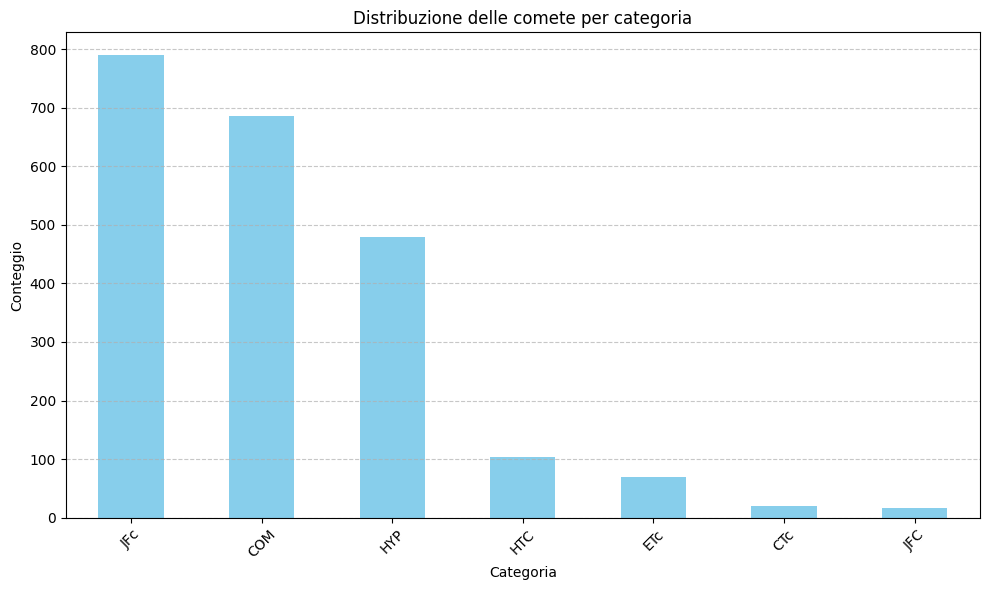

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

comets = pd.read_csv('Comets/c_cleaned.csv')
asteroids = pd.read_csv('Asteroids/a_cleaned.csv')
meteorites = pd.read_csv('Meteorites/ml_cleaned.csv')

category_counts = comets['class'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuzione delle comete per categoria')
plt.xlabel('Categoria')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

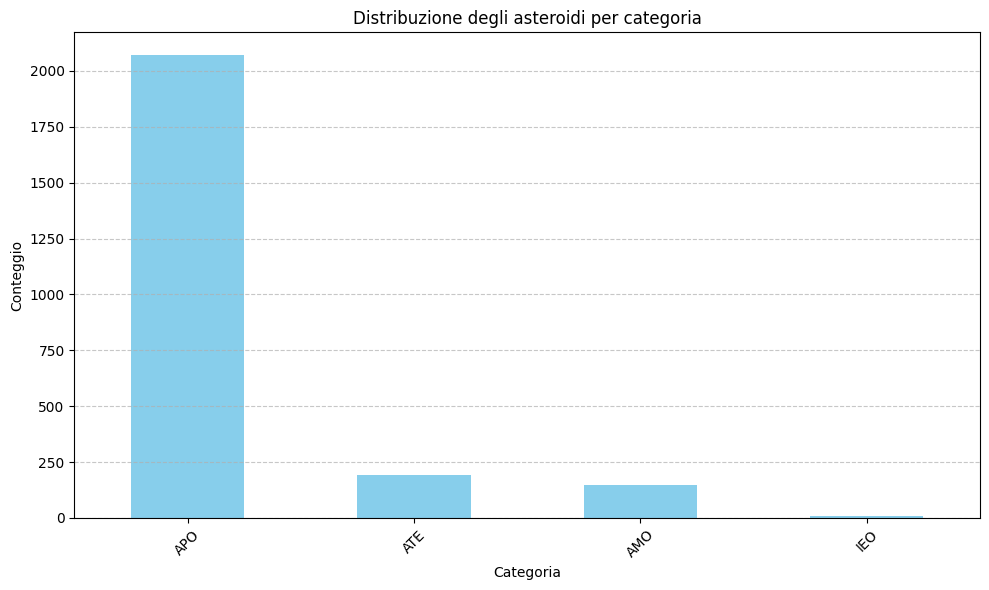

In [16]:
category_counts = asteroids['class'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuzione degli asteroidi per categoria')
plt.xlabel('Categoria')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

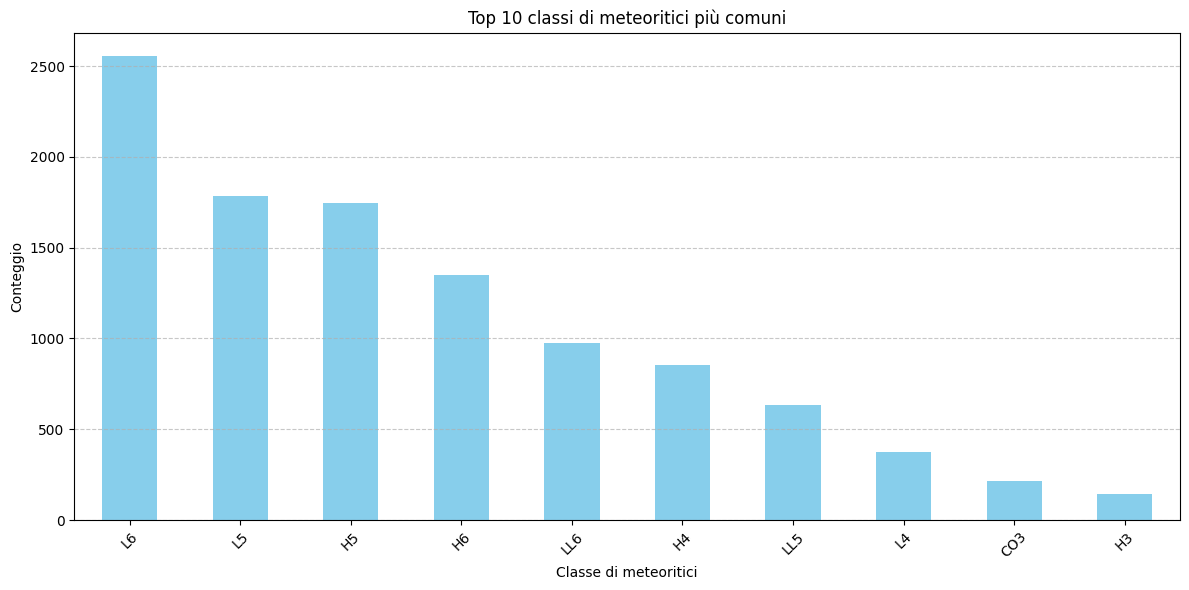

In [24]:
recclass_counts = meteorites['recclass'].value_counts()
top_10_recclass = recclass_counts.head(10)

plt.figure(figsize=(12, 6))
top_10_recclass.plot(kind='bar', color='skyblue')
plt.title('Top 10 classi di meteoriti più comuni')
plt.xlabel('Classe di meteoriti')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostra il grafico
plt.show()

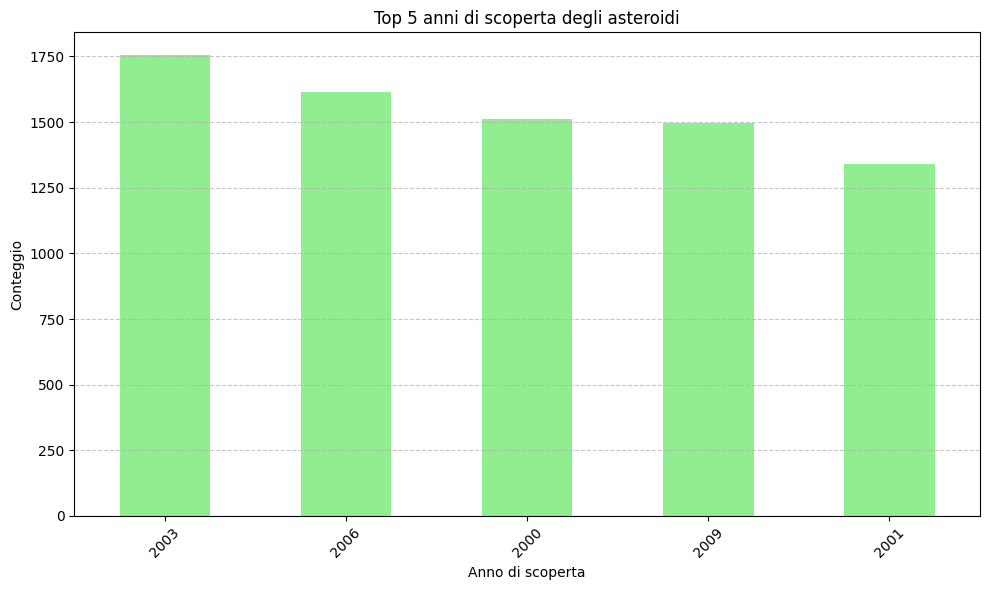

In [29]:
year_counts = meteorites['year'].value_counts()
top_5_years = year_counts.head(5)

plt.figure(figsize=(10, 6))
top_5_years.plot(kind='bar', color='lightgreen')
plt.title('Top 5 anni di scoperta degli asteroidi')
plt.xlabel('Anno di scoperta')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

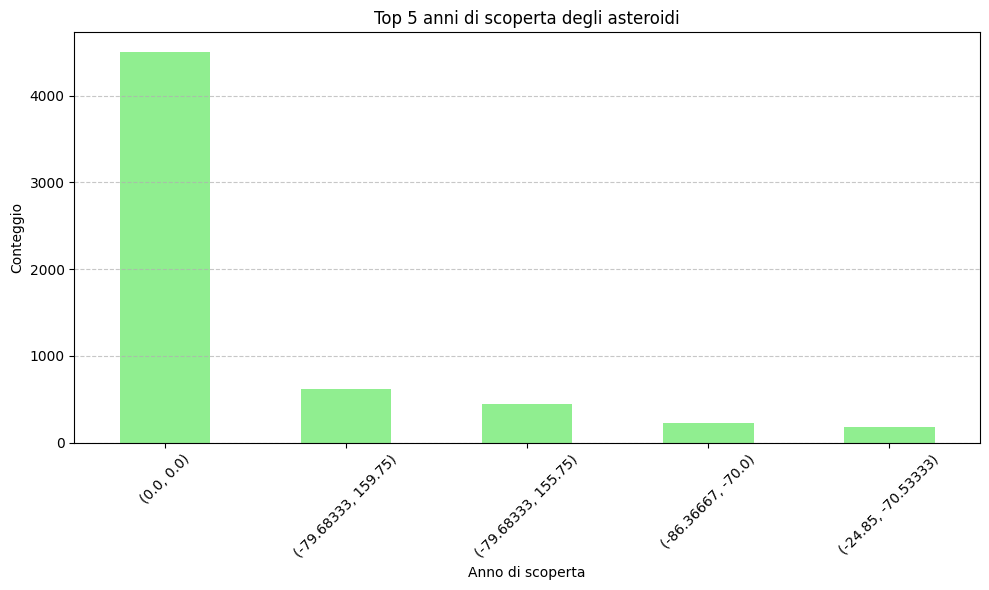

In [30]:
year_counts = meteorites['GeoLocation'].value_counts()
top_5_years = year_counts.head(5)

plt.figure(figsize=(10, 6))
top_5_years.plot(kind='bar', color='lightgreen')
plt.title('Top 5 luoghi con più impatti di meteoriti')
plt.xlabel('Posizione')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

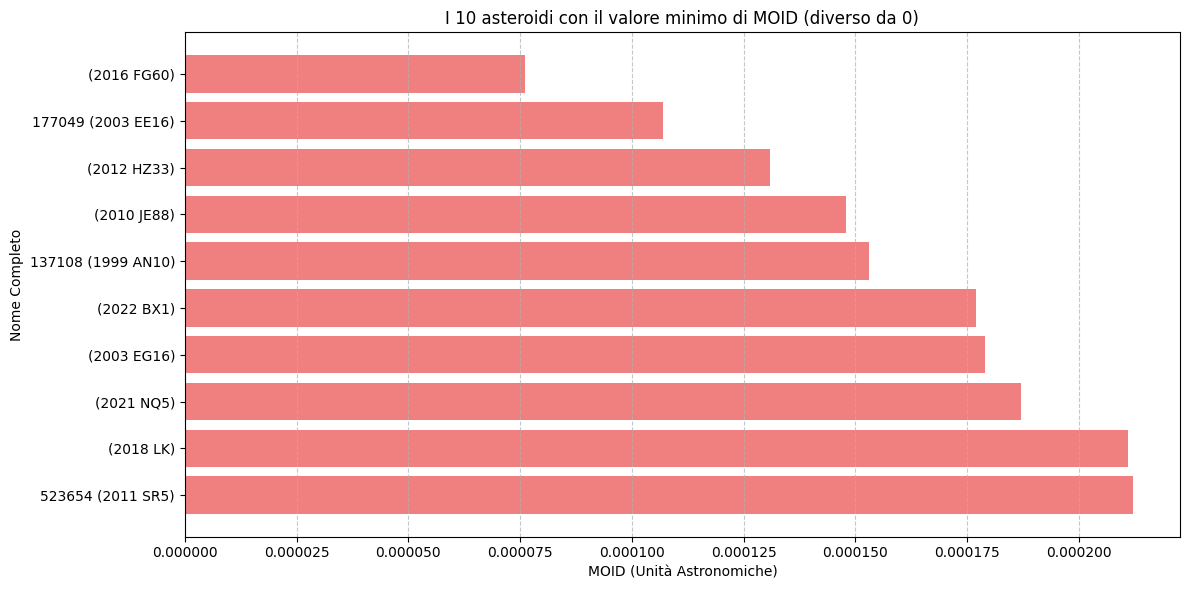

In [14]:
asteroids_non_zero_moid = asteroids[asteroids['moid'] != 0]
asteroids_sorted_by_moid = asteroids_non_zero_moid.sort_values(by='moid', ascending=True)
top_10_min_moid = asteroids_sorted_by_moid.head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_10_min_moid['full_name'], top_10_min_moid['moid'], color='lightcoral')
plt.xlabel('MOID (Unità Astronomiche)')
plt.ylabel('Nome Completo')
plt.title('I 10 asteroidi con il valore minimo di MOID (diverso da 0)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

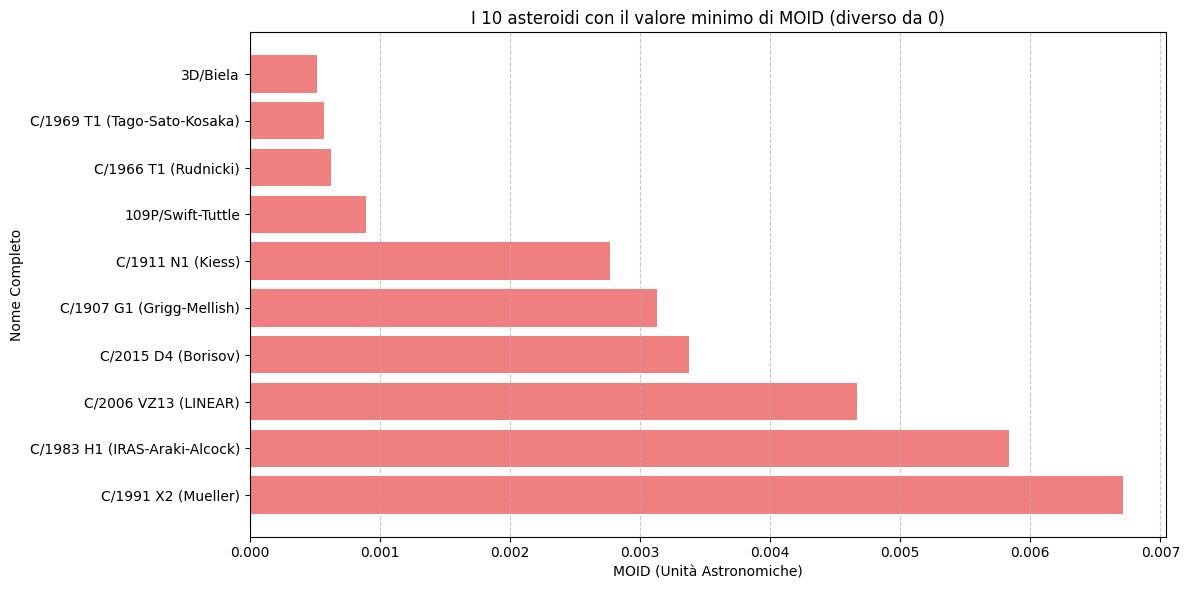

In [12]:
comets_non_zero_moid = comets[comets['moid'] != 0.0]
comets_sorted_by_moid = comets_non_zero_moid.sort_values(by='moid', ascending=True)
top_10_min_moid = comets_sorted_by_moid.head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_10_min_moid['full_name'], top_10_min_moid['moid'], color='lightcoral')
plt.xlabel('MOID (Unità Astronomiche)')
plt.ylabel('Nome Completo')
plt.title('I 10 comete con il valore minimo di MOID (diverso da 0)')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Trasformazione in dati a 5 stelle

Dopo la pulizia siamo ancora in possesso di dati a 3 stelle, per poter passare a 5 stelle dobbiamo per prima cosa creare un'ontologia e successivamente, basandoci sullo standard RDF, creare gli URI per l'indentificazione delle varie resources.

### Ontologia
L'Ontologia è stata creata tramite Protégé e si tratta di una ontologia OWL. La gerarchia delle classi è la seguente: abbiamo inzialmente 2 classi, __Orbit__ e __CelestialBody__, la prima ha come _DatatypeProperties_ tutti i parametri utili alla ricostruzione dell'orbita oltre a _hasProducer_, _category_ e _hasOrbitId_, la seconda invece è composta a sua volta da due classi __Meteorite__ e __OrbitingCelestialBody__. Anche con __Meteorite__ abbiamo che le _DatatypeProperties_ specificate permettono la classificazione del meteorite, in aggiunta alle coordinate geografiche dell'impatto di questo con la superficie terreste, mentre la classe __OrbitingCelestialBody__ è composta infine di due classi: __Comet__ e __Asteroid__. Queste 2 ultime classi hanno le medesime _DatatypeProperties_, a differenza però della classe __Meteorite__ è presente una __ObjectProperties__, in ambedue le classi, __hasOrbti__ che ha come domain la classe __OrbitingCelestialBody__ e range la classe __Orbit__, esiste anche la sua inversa ovvero __orbitOf__ che ha come domain __Orbit__ e come range __OrbitingCelestialBody__.

#### Libreria poliastro
Questa libreria viene usata principalmente per:
- Calcolare il parametro _true anomaly_ accedendo direttamente a quello dell'orbita generata da _from\_sbdb()_, quest'ultima funzione prende i dati da __Small-Body Database__ ossia lo stesso database da cui abbiamo preso i nostri datesets per le comete e gli asteroidi. 
- Creare gli ephem, ossia gli effemeridi, delle varie comete e asteroidi in modo da poter propagare la loro orbita nel tempo. 

In [ ]:
import csv, requests, ast
import pandas as pd
from urllib.parse import quote
from rdflib import Graph, Literal, Namespace, URIRef, RDF, RDFS, OWL, XSD
from SPARQLWrapper import SPARQLWrapper, JSON
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Value
from poliastro.bodies import Sun
from poliastro.twobody import Orbit

In [ ]:
import requests
from requests.adapters import HTTPAdapter
from  urllib3.util.retry import Retry

retry_strategy = Retry(
    total=6,
    status_forcelist=[429, 500, 502, 503, 504], 
    allowed_methods=["HEAD", "GET", "OPTIONS"]  
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("http://", adapter)

In [ ]:
def check_comet_dbpedia(row):
    result = {}
    
    def check_dbpedia(url):
        try:
            r = http.get(url, timeout=10)
            if r.status_code == 200:
                return url
        except Exception as e:
            print(f"Errore durante la richiesta a {url}: {e}")
        return None

    dbpedia_urls = [
        f"http://dbpedia.org/resource/{row['full_name'].replace(' ', '_')}",
        f"http://dbpedia.org/resource/{row['full_name'].split()[0].replace(' ', '_')}",
        f"http://dbpedia.org/resource/{row['pdes']}/{row['name']}",
        f"http://dbpedia.org/resource/{row['full_name'].split('(')[0].strip().replace(' ', '_')}",
        f"http://dbpedia.org/resource/{row['prefix']}/{row['pdes']}",
        f"http://dbpedia.org/resource/{row['full_name'].split('-')[0].replace(' ', '_')}"
    ]

    for url in dbpedia_urls:
        dbpedia_link = check_dbpedia(url)
        if dbpedia_link:
            result[row['spkid']] = dbpedia_link
            break
    
    return result

In [ ]:
def check_asteroid_dbpedia(row):
    result = {}
    
    def check_dbpedia(url):
        try:
            r = http.get(url, timeout=10)
            if r.status_code == 200:
                return url
        except Exception as e:
            print(f"Errore durante la richiesta a {url}: {e}")
        return None

    dbpedia_urls = [
        f"http://dbpedia.org/resource/{row['full_name'].replace(' ', '_')}",
        f"http://dbpedia.org/resource/{row['pdes']}_{row['name']}",
        f"http://dbpedia.org/resource/{'(' + row['pdes'] + ')_' + row['full_name'].split('(')[-1].split(')')[0].replace(' ', '_')}",
        f"http://dbpedia.org/resource/{row['full_name'].split(' (')[0].replace(' ', '_')}"
    ]

    for url in dbpedia_urls:
        dbpedia_link = check_dbpedia(url)
        if dbpedia_link:
            result[row['spkid']] = dbpedia_link
            break
    
    return result

In [ ]:
def check_meteorite_dbpedia(row):
    result = {}
    
    def check_dbpedia(url):
        try:
            r = http.get(url, timeout=10)
            if r.status_code == 200:
                return url
        except Exception as e:
            print(f"Errore durante la richiesta a {url}: {e}")
        return None

    dbpedia_urls = [
        f"http://dbpedia.org/resource/{row['name'].replace(' ', '_')}",
    ]

    for url in dbpedia_urls:
        dbpedia_link = check_dbpedia(url)
        if dbpedia_link:
            result[row['id']] = dbpedia_link
            break
    
    return result

In [ ]:
df = pd.read_csv('Meteorites/ml_cleaned.csv')
meteo_dbpedia = {}
with ThreadPoolExecutor(max_workers=50) as executor:
    for result in executor.map(lambda row: check_meteorite_dbpedia(row), df.to_dict('records')):
        meteo_dbpedia.update(result)

In [ ]:
df = pd.read_csv('Asteroids/a_cleaned.csv')
asteroid_dbpedia = {}
with ThreadPoolExecutor(max_workers=50) as executor:
    for result in executor.map(lambda row: check_asteroid_dbpedia(row), df.to_dict('records')):
        asteroid_dbpedia.update(result)

In [ ]:
df = pd.read_csv('Comets/c_cleaned.csv')
comet_dbpedia = {}
with ThreadPoolExecutor(max_workers=50) as executor:
    for result in executor.map(lambda row: check_comet_dbpedia(row), df.to_dict('records')):
        comet_dbpedia.update(result)

In [ ]:
g = Graph()
base_uri = "http://www.celestial.bodies.org/resource/"
cbo = Namespace("http://www.celestial.bodies.org/ontology/")
g.bind("cbo", cbo)
cbr = Namespace("http://www.celestial.bodies.org/resource/")
g.bind("cbr", cbr)

In [ ]:
def getTrueAnomaly(spkid: str):
    return Orbit.from_sbdb(spkid).nu.value

In [ ]:
with open('Meteorites/ml_cleaned.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uri_meteorite = base_uri + Literal(row['id'])
        g.add([URIRef(uri_meteorite), RDF.type, URIRef(cbo.Meteorite)])
        g.add([URIRef(uri_meteorite), cbo.hasId, Literal(row['id'], datatype=XSD.integer)])
        g.add([URIRef(uri_meteorite), cbo.hasName, Literal(row['name'], datatype=XSD.string)])
        g.add([URIRef(uri_meteorite), cbo.hasNameType, Literal(row['nametype'], datatype=XSD.string)])
        g.add([URIRef(uri_meteorite), cbo.hasLatitude, Literal(row['reclat'], datatype=XSD.float)])
        g.add([URIRef(uri_meteorite), cbo.hasLongitude, Literal(row['reclong'], datatype=XSD.float)])
        g.add([URIRef(uri_meteorite), cbo.hasMass, Literal(row['mass (g)'], datatype=XSD.float)])
        g.add([URIRef(uri_meteorite), cbo.type, Literal(row['recclass'], datatype=XSD.string)])
        g.add([URIRef(uri_meteorite), cbo.year, Literal(row['year'], datatype=XSD.int)])
        g.add([URIRef(uri_meteorite), cbo.fall, Literal(row['fall'], datatype=XSD.string)])
        g.add([URIRef(uri_meteorite), cbo.hasGeographicPosition, Literal(row['GeoLocation'], datatype=XSD.string)])
        if int(row['id']) in meteo_dbpedia: g.add([URIRef(uri_meteorite), OWL.sameAs, URIRef(meteo_dbpedia[int(row['id'])])])

In [ ]:
with open('Asteroids/a_cleaned.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uri_asteroid = base_uri + Literal(row['spkid'])
        g.add([URIRef(uri_asteroid), RDF.type, URIRef(cbo.Asteroid)])
        g.add([URIRef(uri_asteroid), cbo.hasId, Literal(row['spkid'], datatype=XSD.integer)])
        g.add([URIRef(uri_asteroid), cbo.hasFullName, Literal(row['full_name'], datatype=XSD.string)])
        g.add([URIRef(uri_asteroid), cbo.hasOberservations, Literal(row['n_obs_used'], datatype=XSD.integer)])
        g.add([URIRef(uri_asteroid), cbo.hasPrimaryDesignation, Literal(row['pdes'], datatype=XSD.string)])
        g.add([URIRef(uri_asteroid), cbo.hasName, Literal(row['name'], datatype=XSD.string)])
        g.add([URIRef(uri_asteroid), cbo.firstObservation, Literal(row['first_obs'], datatype=XSD.string)])
        g.add([URIRef(uri_asteroid), cbo.lastObservation, Literal(row['last_obs'], datatype=XSD.string)])
        if int(row['spkid']) in asteroid_dbpedia: g.add([URIRef(uri_asteroid), OWL.sameAs, URIRef(asteroid_dbpedia[int(row['spkid'])])])

        uri_orbita = base_uri + Literal(row['orbit_id'].replace(" ", "_").replace("/", "_")) + "_"  + Literal(row['spkid'])
        g.add([URIRef(uri_orbita), RDF.type, URIRef(cbo.Orbit)])
        g.add([URIRef(uri_orbita), cbo.category, Literal(row['class'], datatype=XSD.string)])
        g.add([URIRef(uri_orbita), cbo.hasEccentricity, Literal(row['e'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasInclination, Literal(row['i'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasLongitudeOfTheAscendingNode, Literal(row['om'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasMajorSemiaxis, Literal(row['a'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasMinimumOrbitIntersectionDistance, Literal(row['moid'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasOrbitId, Literal(row['orbit_id'], datatype=XSD.string)])
        g.add([URIRef(uri_orbita), cbo.hasPerihelionArgument, Literal(row['w'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasProducer, Literal(row['producer'], datatype=XSD.string)])
        g.add([URIRef(uri_orbita), cbo.hasTrueAnomaly, Literal(getTrueAnomaly(row['spkid']), datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.orbitOf, URIRef(uri_asteroid)])
        g.add([URIRef(uri_asteroid), cbo.hasOrbit, URIRef(uri_orbita)])

In [ ]:
with open('Comets/c_cleaned.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uri_comet = base_uri + Literal(row['spkid'])
        g.add([URIRef(uri_comet), RDF.type, URIRef(cbo.Comet)])
        g.add([URIRef(uri_comet), cbo.hasId, Literal(row['spkid'], datatype=XSD.integer)])
        g.add([URIRef(uri_comet), cbo.hasFullName, Literal(row['full_name'], datatype=XSD.string)])
        g.add([URIRef(uri_comet), cbo.hasOberservations, Literal(row['n_obs_used'], datatype=XSD.integer)])
        g.add([URIRef(uri_comet), cbo.hasPrimaryDesignation, Literal(row['pdes'], datatype=XSD.string)])
        g.add([URIRef(uri_comet), cbo.hasName, Literal(row['name'], datatype=XSD.string)])
        g.add([URIRef(uri_comet), cbo.firstObservation, Literal(row['first_obs'], datatype=XSD.string)])
        g.add([URIRef(uri_comet), cbo.lastObservation, Literal(row['last_obs'], datatype=XSD.string)])
        if int(row['spkid']) in comet_dbpedia: g.add([URIRef(uri_comet), OWL.sameAs, URIRef(comet_dbpedia[int(row['spkid'])])])

        uri_orbita = base_uri + Literal(row['orbit_id'].replace(" ", "_").replace("/", "_")) + "_"  + Literal(row['spkid'])
        g.add([URIRef(uri_orbita), RDF.type, URIRef(cbo.Orbit)])
        g.add([URIRef(uri_orbita), cbo.category, Literal(row['class'], datatype=XSD.string)])
        g.add([URIRef(uri_orbita), cbo.hasEccentricity, Literal(row['e'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasInclination, Literal(row['i'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasLongitudeOfTheAscendingNode, Literal(row['om'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasMajorSemiaxis, Literal(row['a'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasMinimumOrbitIntersectionDistance, Literal(row['moid'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasOrbitId, Literal(row['orbit_id'], datatype=XSD.string)])
        g.add([URIRef(uri_orbita), cbo.hasPerihelionArgument, Literal(row['w'], datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.hasProducer, Literal(row['producer'], datatype=XSD.string)])
        g.add([URIRef(uri_orbita), cbo.hasTrueAnomaly, Literal(getTrueAnomaly(row['spkid']), datatype=XSD.float)])
        g.add([URIRef(uri_orbita), cbo.orbitOf, URIRef(uri_comet)])
        g.add([URIRef(uri_comet), cbo.hasOrbit, URIRef(uri_orbita)])

/home/coder/.local/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/coder/.local/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [ ]:
g.serialize(destination='Dataset_rdf_final.ttl', format='ttl')

<Graph identifier=Ne9cca9ef3548490595cd45354e4421bd (<class 'rdflib.graph.Graph'>)>

# Bot Telegram

Tramite il bot telegram possiamo esplorare i dati 5 stelle creati, tramite operazioni di search o explorer. Inoltre a seconda della categoria che andremo a selezionare tramite i menù (Comete, Orbite, Asteroidi, Meteoriti) avremo ulteriori operazioni, specifiche per ogni classe, da poter utilizzare. In particolare per quanto riguarde le orbite, è possibile stampare graficamente l'orbita, propagarla ad una determinata data, ottenere la distanza del corpo celeste dalla terra, specificando ovvimente una data. Per quanto riguarda invece i meteoriti, è possibile visualizzare, tramite latitudine e longitudine, il luogo d'impatto su una mappa, a questo scopo è stata utilizzata la libreria _folium_.